In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import context

In [3]:
from IPython.display import display

In [4]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

In [5]:
import os
import pickle
import numpy as np
from datetime import datetime

In [6]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, ToPILImage, Lambda, Compose
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image

In [7]:
from bestiary.criteria.autoencoder import AutoEncoderLoss

In [8]:
from bestiary.nets.wgan import GenerativeAdversarialNet, WassersteinGenerativeAdversarialNet

In [9]:
from bestiary.models import unsupervised

In [89]:
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping, Checkpoint, ProgressBar, Callback
from skorch.callbacks import TensorBoard, BatchScoring, EpochScoring, PassthroughScoring, LRScheduler
from skorch.dataset import CVSplit

In [11]:
import matplotlib.pyplot as plt

In [12]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from tensorboardX import SummaryWriter

In [13]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [14]:
from sklearn.datasets import fetch_openml

In [15]:
from skopt import BayesSearchCV

In [16]:
from scipy.stats import loguniform, randint

In [17]:
from bestiary.models.adversarial.gan import Generator, Discriminator

# Data

In [41]:
mnist = MNIST('data', download=True, transform=Compose([ToTensor(), Lambda(lambda x: x.reshape(28, 28))]))

In [363]:
class Painter(nn.Module):
    
    def __init__(self, hidden_dim=32, n_layers=5):
        
        super(Painter, self).__init__()
        
        self.module = nn.Sequential(
            nn.Linear(3, hidden_dim),
            nn.ReLU(),
            *[
                nn.Sequential(
                    nn.Linear(hidden_dim, hidden_dim),
                    nn.ReLU(),
                )
                for _ in range(n_layers)
            ],
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        return self.module(x)

In [364]:
module = Painter()

In [365]:
module = nn.Sequential(
    nn.Linear(2, 20),
    nn.Tanh(),
    nn.Linear(20, 20),
    nn.Tanh(),
    nn.Linear(20, 20),
    nn.Tanh(),
    nn.Linear(20, 20),
    nn.Tanh(),
    nn.Linear(20, 20),
    nn.Tanh(),
    nn.Linear(20, 1),
    nn.Sigmoid(),
)

In [366]:
module(torch.rand(2, 2))

tensor([[0.5590],
        [0.5581]], grad_fn=<SigmoidBackward>)

In [367]:
x, i = mnist[100]

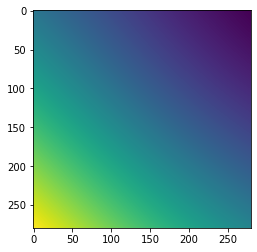

In [368]:
pixels = 280

grid = torch.stack((
    torch.linspace(0, 1, pixels).view(-1, 1).repeat(1, pixels),
    torch.linspace(0, 1, pixels).view(1, -1).repeat(pixels, 1),
), dim=-1)

plt.imshow(module(grid.view(-1, 2)).view(pixels, pixels).detach())

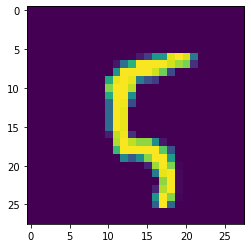

In [369]:
plt.imshow(x)

In [376]:
def create_dataset(image):
    h, w = image.shape
    
    X = torch.stack((
        torch.linspace(0, 1, h).view(-1, 1).repeat(1, h),
        torch.linspace(0, 1, w).view(1, -1).repeat(w, 1),
    ), dim=-1).view(-1, 2)
    y = image.view(-1, 1)
    
    X = torch.cat((X, (X - .5).norm(dim=1, keepdim=True)), dim=1)
    
    return X, y

In [386]:
x, _ = mnist[np.random.randint(len(mnist))]

In [387]:
X, y = create_dataset(x)

In [399]:
painter = NeuralNetRegressor(
    module=Painter,
    module__hidden_dim=256,
    module__n_layers=2,
    batch_size=5,
    iterator_train__shuffle=True,
    train_split=CVSplit(10),
    optimizer=torch.optim.Adam,
    lr=1e-3,
    max_epochs=40,
    verbose=0,
    callbacks=[
       ('scheduler', LRScheduler(monitor='train_loss', patience=2, policy=torch.optim.lr_scheduler.ReduceLROnPlateau)),
    ]
)

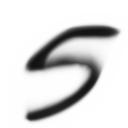

In [412]:
x, _ = mnist[np.random.randint(len(mnist))]
X, y = create_dataset(x)

painter.fit(X, y)

show(painter, 128)

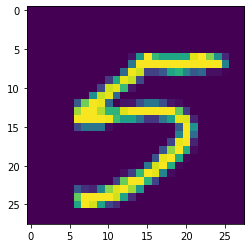

In [413]:
plt.imshow(y.reshape(28, 28))

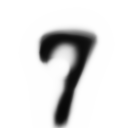

In [410]:
n = 128
image = predict_image(painter, n)
to_pil_image(1 - torch.tensor(image).reshape(1, n, n))

In [402]:
def predict_image(net, pixels=28):

    grid = torch.stack((
        torch.linspace(0, 1, pixels).view(-1, 1).repeat(1, pixels),
        torch.linspace(0, 1, pixels).view(1, -1).repeat(pixels, 1),
    ), dim=-1).view(-1, 2)

    grid = torch.cat((grid, (grid - .5).norm(dim=1, keepdim=True)), dim=1)
    
    return net.predict(grid).reshape(pixels, pixels)

In [407]:
def show(net, pixels):
    image = predict_image(painter, pixels)
    return to_pil_image(1 - torch.tensor(image).reshape(1, pixels, pixels))

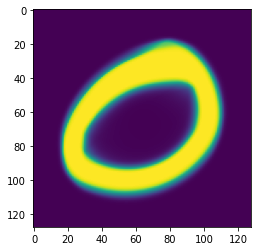

In [395]:
pixels = 128

grid = torch.stack((
    torch.linspace(0, 1, pixels).view(-1, 1).repeat(1, pixels),
    torch.linspace(0, 1, pixels).view(1, -1).repeat(pixels, 1),
), dim=-1).view(-1, 2)

grid = torch.cat((grid, (grid - .5).norm(dim=1, keepdim=True)), dim=1)

image = painter.predict(grid).reshape(pixels, pixels)

plt.imshow(image)

In [360]:
image

array([[3.5578119e-38, 4.0667772e-38, 4.6485885e-38, ..., 1.1844918e-18,
        1.0783974e-18, 9.8179835e-19],
       [3.8281739e-38, 4.3758496e-38, 5.0018777e-38, ..., 1.2490888e-18,
        1.1371999e-18, 1.0353375e-18],
       [4.1207785e-38, 4.7102434e-38, 5.3839473e-38, ..., 1.3171988e-18,
        1.1992180e-18, 1.0918003e-18],
       ...,
       [5.9638118e-29, 7.0746960e-29, 8.3925039e-29, ..., 4.0062027e-23,
        3.6958717e-23, 3.4095143e-23],
       [5.5697094e-29, 6.6071326e-29, 7.8378482e-29, ..., 3.7228839e-23,
        3.4344997e-23, 3.1683936e-23],
       [5.2016106e-29, 6.1705176e-29, 7.3199048e-29, ..., 3.4595754e-23,
        3.1916116e-23, 2.9443473e-23]], dtype=float32)

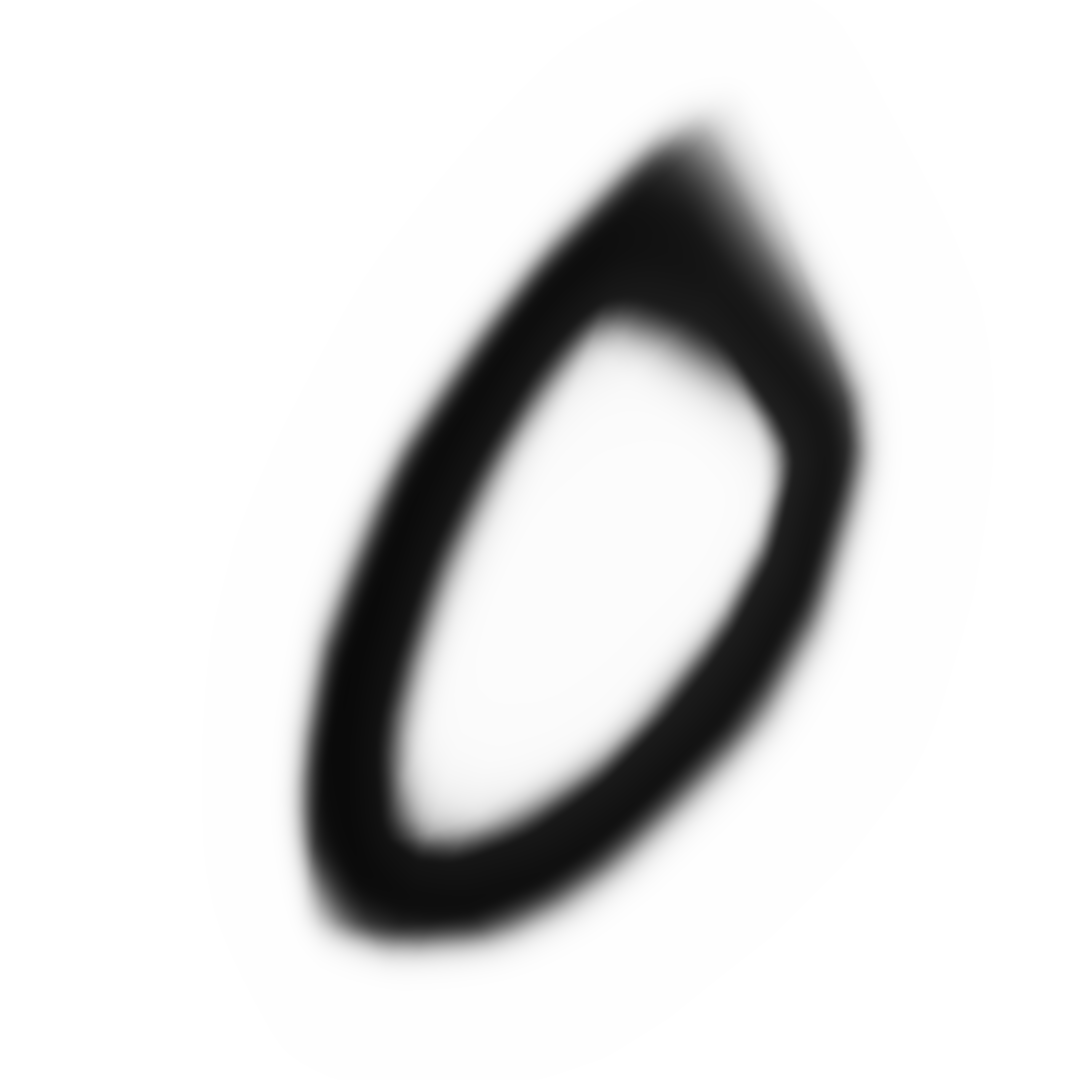

In [362]:
to_pil_image(1 - torch.tensor(image).reshape(1, 1080, 1080))